In [36]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import shutil
from sklearn.model_selection import train_test_split
import cv2 as cv
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [37]:
ListeComposantPC = []

proportion_train = 0.8
donnees = []
etiquettes = []


In [38]:
for element in os.listdir("pc_parts"):
    chemin_element = os.path.join("pc_parts", element)
    if os.path.isdir(chemin_element):
        ListeComposantPC.append(element)

In [39]:
print(ListeComposantPC)

['cables', 'case', 'cpu', 'gpu', 'hdd', 'headset', 'keyboard', 'microphone', 'monitor', 'motherboard', 'mouse', 'ram', 'speakers', 'webcam']


In [40]:

for idx, composant in enumerate(ListeComposantPC):
    chemin_composant = os.path.join("pc_parts", composant)
    fichiers = [f for f in os.listdir(chemin_composant) if os.path.isfile(os.path.join(chemin_composant, f))]

    for fichier in fichiers:
        img_path = os.path.join(chemin_composant, fichier)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.resize(img, (256, 256))  # Assurer la dimension attendue par le modèle
            donnees.append(img) 
            etiquettes.append(idx)



In [41]:
donnees = np.array(donnees)
etiquettes = np.array(etiquettes)
X_train, X_test, Y_train, Y_test = train_test_split(donnees, etiquettes, test_size=1-proportion_train, random_state=42)

print(f"Données d'entraînement : {X_train.shape}, Étiquettes d'entraînement : {Y_train.shape}")
print(f"Données de test : {X_test.shape}, Étiquettes de test : {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0


Données d'entraînement : (2623, 256, 256, 3), Étiquettes d'entraînement : (2623,)
Données de test : (656, 256, 256, 3), Étiquettes de test : (656,)


In [42]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [43]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(ListeComposantPC), activation='softmax')  # Output layer with softmax activation
])

In [44]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

NameError: name 'optimizers' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:


history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    validation_data=(X_test, Y_test),
                    epochs=20,
                    callbacks=[early_stopping])

Epoch 1/50
82/82 [==============================] - 190s 2s/step - loss: 8.0823 - accuracy: 0.0705 - val_loss: 21.5421 - val_accuracy: 0.0579 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 166s 2s/step - loss: 2.8190 - accuracy: 0.0843 - val_loss: 12.6903 - val_accuracy: 0.0442 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 165s 2s/step - loss: 2.6814 - accuracy: 0.0839 - val_loss: 4.1750 - val_accuracy: 0.0716 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 165s 2s/step - loss: 2.6768 - accuracy: 0.0884 - val_loss: 2.7291 - val_accuracy: 0.1052 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 165s 2s/step - loss: 2.8626 - accuracy: 0.0884 - val_loss: 3.7104 - val_accuracy: 0.1113 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - 167s 2s/step - loss: 2.6527 - accuracy: 0.0892 - val_loss: 2.6521 - val_accuracy: 0.0991 - lr: 9.0000e-04
Epoch 7/50
82/82 [==============================] - 180s 2s/step - los

In [ ]:
model.save('detecPc.h5')  # Enregistre le modèle dans un fichier HDF5

In [ ]:
def AfficherImage(cheminImage):
    img = mpimg.imread(cheminImage)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
def AfficherImageRandom():
    PCpartie = random.choice(ListeComposantPC)
    chemin_PCpartie = os.path.join("pc_parts", PCpartie)
    fichiers = os.listdir(chemin_PCpartie)
    image_random = random.choice(fichiers)
    chemin_image = os.path.join(chemin_PCpartie, image_random)
    AfficherImage(chemin_image)
    return chemin_image, PCpartie  # Retourner aussi le label de la classe


In [ ]:
def preparer_et_predire(chemin_image, model):
    img = cv.imread(chemin_image)  
    img = cv.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)  
    predicted_class = np.argmax(prediction)
    return predicted_class

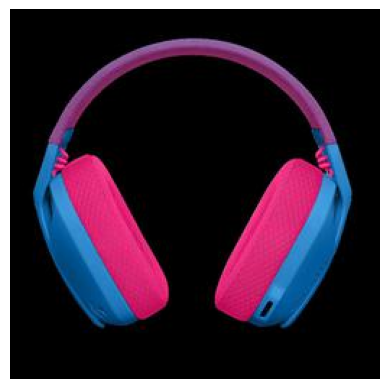

1/1 [==============================] - 0s 137ms/step
Classe réelle : headset
Label prédit : speakers


In [ ]:
modelload = load_model('detecPc.h5')

# Obtenir une image et son label de classe réel
chemin_image, classe_reelle = AfficherImageRandom()
predicted_class = preparer_et_predire(chemin_image, modelload)

# Obtenez le label prédit à partir de l'index
predicted_label = ListeComposantPC[predicted_class]

print("Classe réelle :", classe_reelle)
print("Label prédit :", predicted_label)

In [ ]:
label = ListeComposantPC[predicted_class]
print("Label prédit :", label)

Label prédit : speakers


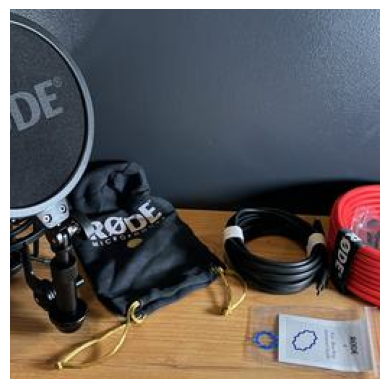

('pc_parts\\microphone\\113.jpg', 'microphone')


In [ ]:

print(AfficherImageRandom())